# Modèle VAR stationnaire : revenu disponible et consommation des ménages aux Etats-Unis

Installation des packages

In [29]:
#install.packages("data.table")
#remotes::install_github("dbnomics/rdbnomics", build_vignettes = TRUE, force = TRUE)
#install.packages("ggplot2")
#install.packages("reshape2")
#install.packages("vars")
install.packages("lpirfs")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘miscTools’, ‘rbibutils’, ‘iterators’, ‘bdsmatrix’, ‘collapse’, ‘maxLik’, ‘Rdpack’, ‘Formula’, ‘doParallel’, ‘foreach’, ‘gridExtra’, ‘plm’, ‘RcppArmadillo’




On utilise un modèle VAR pour étudier les relations entre le taux de croissance du revenu disponible et le taux de croissance de la consommation des ménages aux Etats-Unis. On importe des données réelles, désaisonnalisées et trimestrielles à partir du site [DB.nomics](https://db.nomics.world/).

On verra successivement :

1. l'estimation d'un modèle VAR
2. les tests de causalité au sens de Granger
3. l'analyse impulsion réponse
4. la prévision

De plus, on étudiera l'impact de l'inclusion de la période covid sur les estimations et comment essayer de prendre en compte cette période particulière.

## Importation des données depuis DB.nomics

In [4]:
library(data.table)
library(rdbnomics)

# données sur le revenu disponible réel
data_inc<-rdb(ids = "BEA/NIPA-T20100/A067RX-Q")

# données sur les dépenses de consommation personnelles en volume
data_cons<-rdb(ids = "BEA/NIPA-T10106/DPCERX-Q")

# données sur le revenu disponible réel excluant les transfets sociaux
data_inc_wt<-rdb(ids = "BEA/NIPA-T20100/W875RX-Q")

Visit <https://db.nomics.world>.




On sélectionne les dates et les séries pour le revenu et la consommation qui sont fusionnées dans un seul dataframe. On conserve les données à partir de "1990-01-01".

In [5]:
df_inc<-data_inc[,c("period","value")]
colnames(df_inc)<-c("date","income")
df_cons<-data_cons[,c("period","value")]
colnames(df_cons)<-c("date","consumption")
df<-merge(df_inc,df_cons,by="date")
df<-df["1980-01-01"<=df$date,]

Les deux séries sont représentées sur le graphique ci-dessous. Les deux séries augmentent à un rythme régulier et en parallèle de 1990 à 2008. Les années 2008 et 2009 sont marquées par une baisse des deux séries, plus grande pour la consommation. Les deux séries connaissent ensuite une hausse régulière, à un rythme moins élevé qu'avant 2008, jusqu'au déclenchement de l'épidémie de covid au début de l'année 2020. On observe alors
une forte baisse temporaire de la consommation des ménages, qui retrouve ensuite son rythme de croissance. En raison des transferts sociaux aux ménages, le revenu disponible augmente fortement à deux reprises.


Attaching package: ‘reshape2’


The following objects are masked from ‘package:data.table’:

    dcast, melt




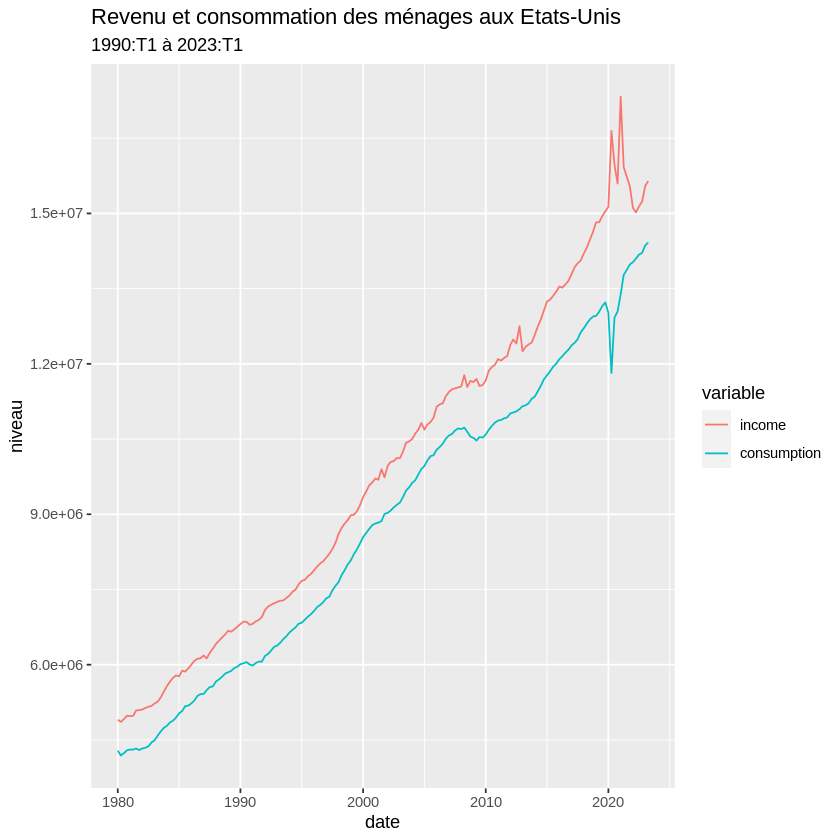

In [6]:
library(ggplot2)
library(reshape2)
data_melt=melt(as.data.frame(df),id.vars = 1)

p_us_T<-ggplot(data=data_melt,aes(x=date))+geom_line(aes(x=date,y=value,color=variable))
p_us_T+labs(y="niveau",title = "Revenu et consommation des ménages aux Etats-Unis",
            subtitle = "1990:T1 à 2023:T1")

## Etude sur la période avant covid : 1990:T1 à 2019:T4

En raison de la spécificité de la période du covid, on se limite dans un premier temps à la période 1990:T1 à 2020:T1.

In [7]:
df_short<-df["1990-01-01"<=df$date & df$date<"2020-01-01",]

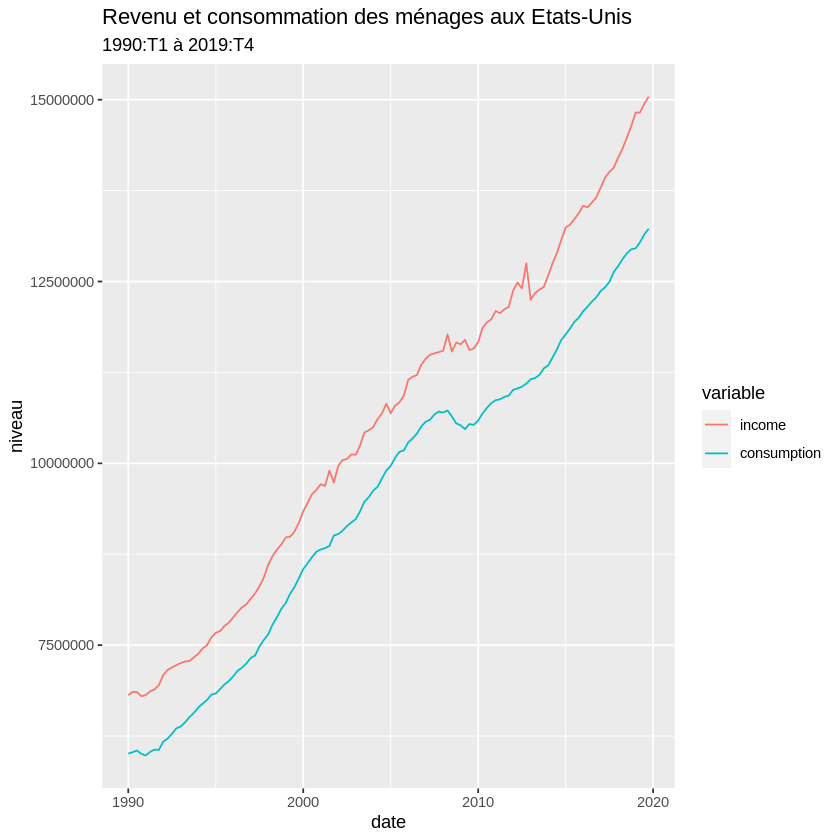

In [8]:
data_melt=melt(as.data.frame(df_short),id.vars = 1)

p_us<-ggplot(data=data_melt,aes(x=date))+geom_line(aes(x=date,y=value,color=variable))
p_us+labs(y="niveau",title = "Revenu et consommation des ménages aux Etats-Unis",
          subtitle = "1990:T1 à 2019:T4")

### Taux de croissance du revenu disponible et de la consommation

On calcule les taux de croissance comme la différence première de variables en logarithme.

In [9]:
df_g_short<-data.frame(df_short$date[-1],diff(log(df_short$income)),diff(log(df_short$consumption)))
# on perd une observation en calculant le taux de croissance
colnames(df_g_short)<-c("date","g_inc","g_cons")

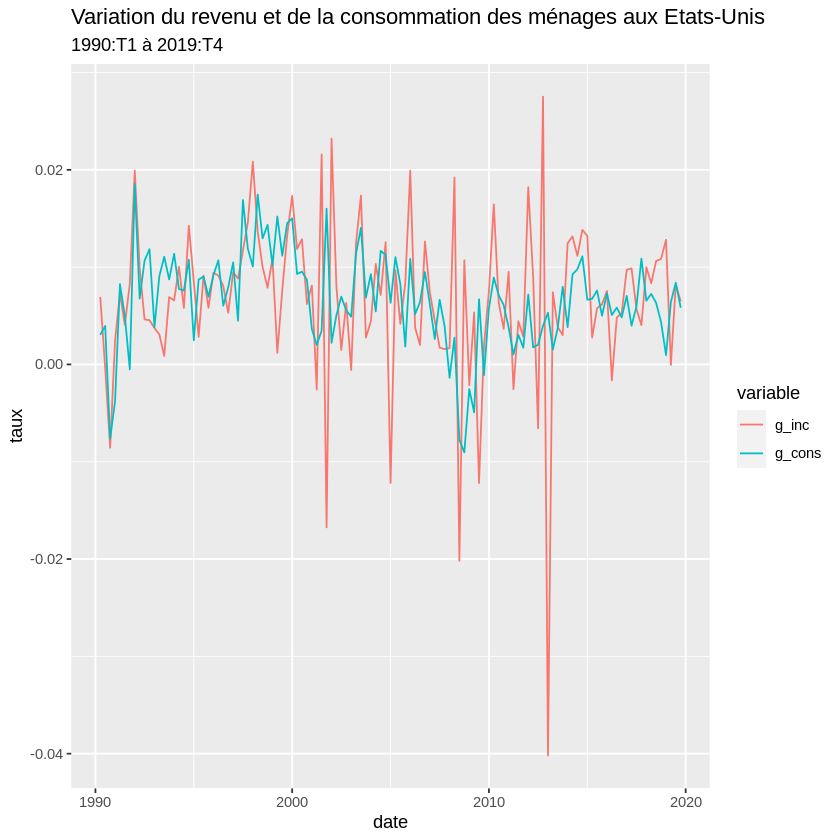

In [10]:
data_melt=melt(as.data.frame(df_g_short),id.vars = 1)

p_g_us<-ggplot(data=data_melt,aes(x=date))+geom_line(aes(x=date,y=value,color= variable))
p_g_us+labs(y="taux",title = "Variation du revenu et de la consommation des ménages aux Etats-Unis",
            subtitle = "1990:T1 à 2019:T4")

#### Statistiques descriptives

In [11]:
summary(df_g_short[c("g_inc","g_cons")])
sapply(df_g_short[c("g_inc","g_cons")],sd)

     g_inc               g_cons         
 Min.   :-0.040186   Min.   :-0.009040  
 1st Qu.: 0.003696   1st Qu.: 0.003943  
 Median : 0.007388   Median : 0.006702  
 Mean   : 0.006658   Mean   : 0.006628  
 3rd Qu.: 0.010665   3rd Qu.: 0.009515  
 Max.   : 0.027518   Max.   : 0.018550  

g_inc      g_cons 
0.008440164 0.004900454

Les statistiques descriptives montrent que les moyennes des deux taux de croissance sont quasiment égales. Le taux de croissance du revenu est plus variable que celui de la consommation, comme le montrent les écarts types, les maxima et minima.


La corrélation entre les deux taux de croissance est égale à 0.28 et significative.

In [12]:
cor.test(df_g_short$g_inc,df_g_short$g_cons)


	Pearson's product-moment correlation

data:  df_g_short$g_inc and df_g_short$g_cons
t = 3.1633, df = 117, p-value = 0.001988
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.1060522 0.4385294
sample estimates:
      cor 
0.2806897 


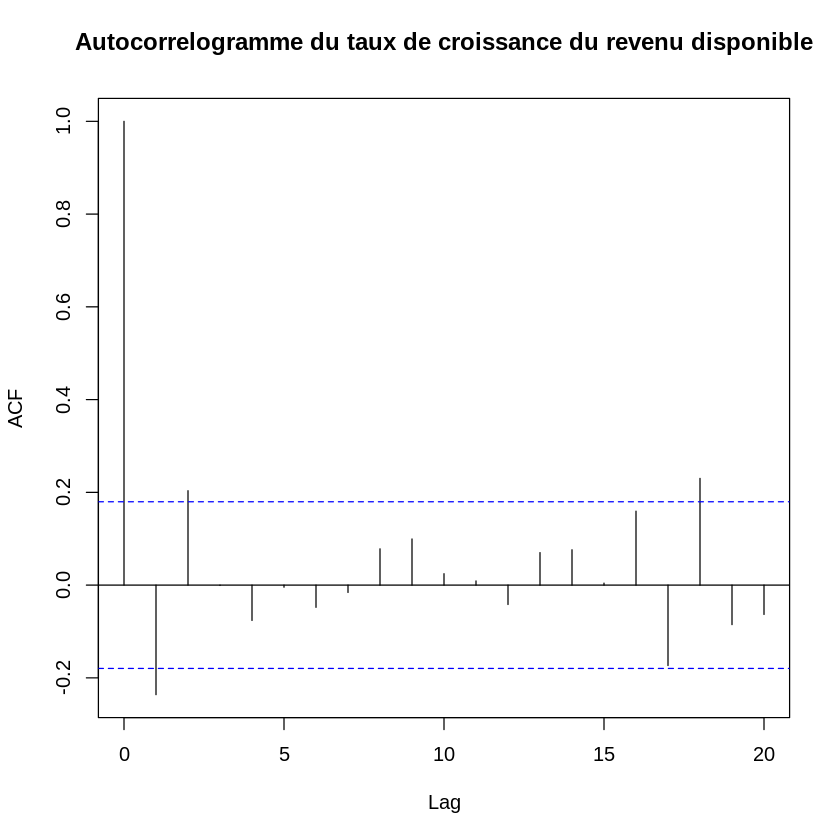

In [13]:
acf(df_g_short$g_inc,main="Autocorrelogramme du taux de croissance du revenu disponible")

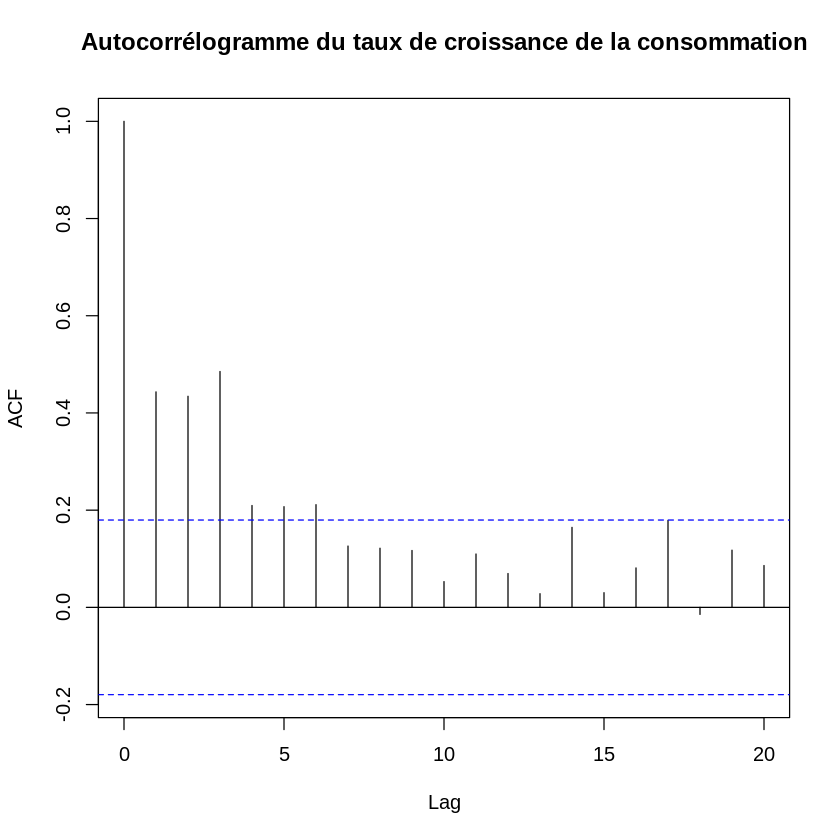

In [14]:
acf(df_g_short$g_cons,main="Autocorrélogramme du taux de croissance de la consommation")

### Modélisation VAR



On utilise la librairie "vars" pour estimer le modèle VAR.



#### Sélection du nombre de retards optimal

On commence par déterminer le nombre de retards par l'application de critères d'information multivariés. On doit spécifier :

* lag.max = nombre maximal de retards
* type = forme de la composante déterministe "const", "trend","both" ou "none (1 seule spécification possible)

On choisit un nombre de retards maximum égal à 8 (correspond à deux années de recul pour des données trimestrielles) et l'on estime un modèle VAR avec une constante (la moyenne des taux de croissance n'est pas nulle.)

In [17]:
library(vars)
pselect<-VARselect(y=df_g_short[,c(2,3)],lag.max=8,type=c("const"))
pselect$criteria # Affichage des valeurs des critère de sélection
pselect$selection # nombre de retards optimal selon les critères de sélection

Loading required package: MASS

Loading required package: strucchange

Loading required package: zoo


Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric


Loading required package: sandwich

Loading required package: urca

Loading required package: lmtest



,1,2,3,4,5,6,7,8
AIC(n),-2.078390e+01,-2.084549e+01,-2.087726e+01,-2.090670e+01,-2.086971e+01,-2.081628e+01,-2.078384e+01,-2.073989e+01
HQ(n),-2.072448e+01,-2.074646e+01,-2.073862e+01,-2.072846e+01,-2.065186e+01,-2.055882e+01,-2.048677e+01,-2.040320e+01
SC(n),-2.063744e+01,-2.060139e+01,-2.053552e+01,-2.046732e+01,-2.033269e+01,-2.018162e+01,-2.005154e+01,-1.990994e+01
FPE(n),9.411924e-10,8.850601e-10,8.575651e-10,8.329976e-10,8.649020e-10,9.131489e-10,9.443564e-10,9.883045e-10


AIC(n)  HQ(n)  SC(n) FPE(n) 
     4      2      1      4

Le nombre de retard optimal varie selon le critère :

* le critère AIc préconise 4 retards,
* le critère HQ préconise 2 retards,
* le critère SC préconise 1 retard,
* le nombre de retards optimaux sont néanmoins inférieurs à lag.max

Le critère AIC est connu pour surestimer le nombre de retards. On décide d'estimer le modèle VAR avec 1 retard.



#### Estimation d'un modèle VAR(1)

In [18]:
var.1lag <-VAR(y = df_g_short[,c("g_inc","g_cons")],type="const",lag.max = 1)
summary(var.1lag) #Affichage des résultats avec summary


VAR Estimation Results:
Endogenous variables: g_inc, g_cons 
Deterministic variables: const 
Sample size: 118 
Log Likelihood: 888.19 
Roots of the characteristic polynomial:
0.4705 0.4153
Call:
VAR(y = df_g_short[, c("g_inc", "g_cons")], type = "const", lag.max = 1)


Estimation results for equation g_inc: 
g_inc = g_inc.l1 + g_cons.l1 + const 

           Estimate Std. Error t value Pr(>|t|)    
g_inc.l1  -0.326877   0.089475  -3.653 0.000391 ***
g_cons.l1  0.556250   0.154122   3.609 0.000456 ***
const      0.005141   0.001259   4.085 8.19e-05 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


Residual standard error: 0.007874 on 115 degrees of freedom
Multiple R-Squared: 0.1519,	Adjusted R-squared: 0.1371 
F-statistic:  10.3 on 2 and 115 DF,  p-value: 7.7e-05 


Estimation results for equation g_cons: 
g_cons = g_inc.l1 + g_cons.l1 + const 

           Estimate Std. Error t value Pr(>|t|)    
g_inc.l1  0.1266923  0.0490151   2.585    0.011 *  
g_cons.l1 0.382

**Commentaires des résultats**

g_inc.li et g_cons.li représentent respectivement $\mathrm{g_{}\_inc}$ et g_cons avec un retard de i périodes.


* Equation du taux de croissance g_inc
    * le coefficient de g_inc.l1 est significatif et négatif pour un risque de première espèce de 1\% : on a tendance à observer une alternance d'accéleration et de ralentissement du taux de croissance trimestriel du revenu disponible.
    * le coefficient de g_cons.l1 est positif et significatif pour un risque de première espèce 1\%,
    * la constante est significative pour un risque de première espèce de 1\%.
    * le $R^{2}$ est égal à 15\%.
    
* Equation du taux de croissance g_cons
    * le coefficient de g_inc.l1 est positif et significatif pour un risque de première espèce de 1\% ; une accélération de la croissance du revenu disponible a pour effet d'accélérer la croissance de la consommation
    * le coefficient de g_cons.l1 est positif et significatif pour un risque de première espèce 1\% : le taux de croissance de la consommation est positivement corréle à sa valeur passée
    * la constante est significative pour un risque de première espèce de 1\%,
    * le $R^{2}$ est égal à 24\% : le pouvoir explicatif de la régression est plus important que pour g_inc
  


On peut afficher les graphiques des valeurs ajustées et des résidus pour chaque variables du VAR.



##### Affichage des racines du polynôme caractéristique

On étudie la stationnarité du VAR. La fonction roots renvoie les module des inverses des racines du polynôme caractéristique.

In [ ]:
roots(var.1lag)

Les inverses des racines sont de module strictement inférieur à 1 : la condition de stationnarité est donc satisfaite.

##### Affichage de résultats

* **Exemple 1 : Liste des matrices des coefficients estimés du VAR**

In [19]:
A<-Acoef(var.1lag)
A

,g_inc.l1,g_cons.l1
g_inc,-0.3268771,0.5562500
g_cons,0.1266923,0.3821523


* **Exemple 2 : Variable ajustée du taux de croissance du revenu g_inc**


Warning message in plot.xy(xy, type, ...):
“plot type 'line' will be truncated to first character”


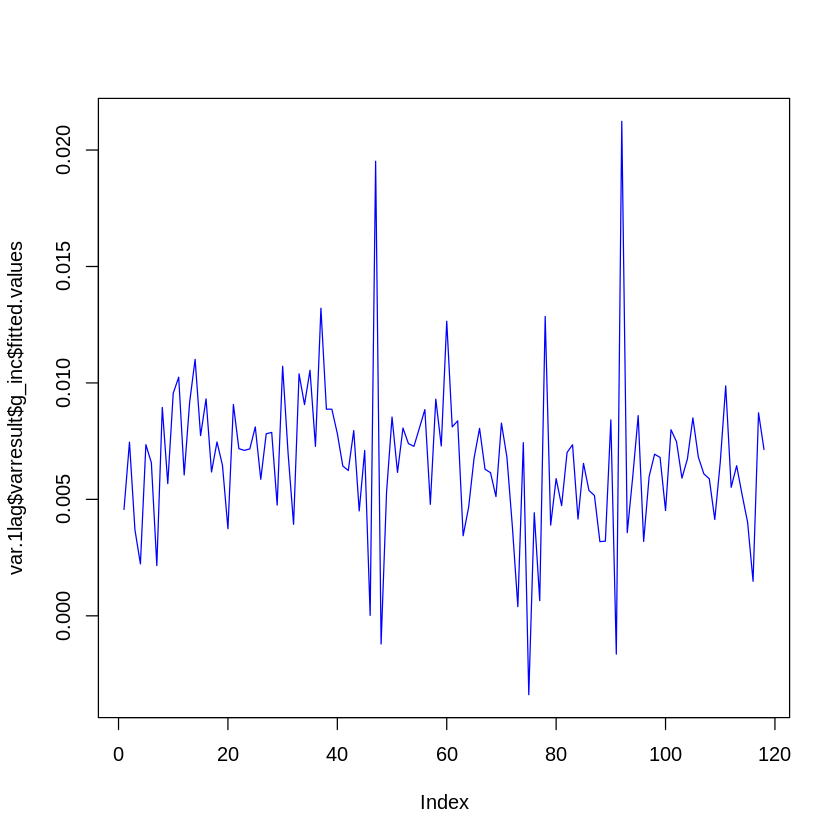

In [20]:
plot(var.1lag$varresult$g_inc$fitted.values,type='line',col='blue')

#### Test de causalité au sens de Granger

##### Causalité de la consommation sur le revenu

On vérifie la significativité du coefficient de $g\_conso_{t-1}$ dans l'équation de $g\_income_{t}$. Les hypothèses du test sont :

$$
\left\lbrace
\begin{array}{l}
H_{0} : a_{12}^{1}=0\Rightarrow\,g\_conso\,\mathrm{ne\,cause\,pas}\,g\_income\\
H_{a} : a_{12}^{1}\neq 0 \Rightarrow\,g\_conso\,\mathrm{cause}\,g\_income
\end{array}
\right.
$$

où $a_{12}^{1}$ est le coefficient de la ligne 1 et colonne 2 de $A$. Les résultats du test figurent ci-dessous :

In [21]:
causality(var.1lag,cause=c('g_cons'))

$Granger

	Granger causality H0: g_cons do not Granger-cause g_inc

data:  VAR object var.1lag
F-Test = 13.026, df1 = 1, df2 = 230, p-value = 0.000377


$Instant

	H0: No instantaneous causality between: g_cons and g_inc

data:  VAR object var.1lag
Chi-squared = 10.046, df = 1, p-value = 0.001527



Les seuils critiques sont tirés d'une loi $F(1,224)$ :

| $\alpha$                  | 5\%  | 10\% |
|---------------------------|------|------|
| $f_{1-\alpha}(1,+\infty)$ | 2.99 | 4.60 |

La statistique de test égale à 5.93 est supérieure au seuil critique pour $\alpha=1\%$. On rejette donc l'hypothèse nulle d'absence de causalité du taux de croissance de la consommation sur le taux de croissance du revenu. La probabilité critique du test est égale à 0,00\% ce qui amène aux mêmes conclusions.  


##### Causalité du revenu sur la consommation

On teste si le taux de croissance du revenu ``cause'' le taux de croissance de la consommation au sens de Granger.

On vérifie la significativité du coefficient de $g\_income_{t-1}$ dans l'équation de $g\_consumption_{t}$. Les hypothèses du test sont :

$$
\left\lbrace
\begin{array}{l}
H_{0} : a_{21}^{1}=0\Rightarrow\,g\_income\,\mathrm{ne\,cause\,pas}\,g\_consumption\\
H_{a} : a_{21}^{1}\neq 0 \Rightarrow\,g\_income\,\mathrm{cause}\,g\_consumption
\end{array}
\right.
$$

où $a_{21}^{1}$ est le coefficient de la ligne 2 et colonne 1 de $A_{1}$. Les résultats du test figurent ci dessous :

In [22]:
causality(var.1lag,cause=c('g_inc'))

$Granger

	Granger causality H0: g_inc do not Granger-cause g_cons

data:  VAR object var.1lag
F-Test = 6.681, df1 = 1, df2 = 230, p-value = 0.01036


$Instant

	H0: No instantaneous causality between: g_inc and g_cons

data:  VAR object var.1lag
Chi-squared = 10.046, df = 1, p-value = 0.001527




La statistique de test égale à 2.58  est supérieure aux seuils critiques. On rejette donc l'hypothèse nulle d'absence de causalité du taux de croissance du revenu sur le taux de croissance de la consommation pour un risque de première espèce de 5\%. La probabilité critique du test est égale à 0.020 ce qui amène aux mêmes conclusions.

##### Conclusion


On observe que le taux de croissance de la consommation le taux de croissance du revenu au sens de Granger et réciproquement. La causalité s'exerce dans ls deux sens et l'on parle alors d'**effet feedback**.

#### Fonctions impulsion-réponse



Comme chacune des deux variables du VAR cause l'autre, les tests de causalité au sens de Granger ne permette pas de dégager un ordre de classement des variables. Néanmoins on peut raisonnablement penser que les chocs sur le taux de croissance du revenu impactent instantanément le taux de croissance de la consommation plutôt que l'inverse. On décide de ``placer'' le taux de croissance du revenu g_income en première ligne et le taux de croissance de la consommation g\_conso en seconde position.

On calcule les fonctions impulsion réponse :

* var.1lag : objet
* n.ahead : nombre de périodes futures pour lesquelles on calcule les impulsion réponse
* ortho = TRUE : on applique la décomposition de Cholesky
* ci = 0.95 : on représente les bornes de l'intervalle de confiance à 95 \% pour déterminer la significativité des IRF.

Les chocs sont égaux à 1 écart type du choc structurel.

**Important**

*   En spécifiant les variables du VAR(1) on a écrit:

> var.1lag <-VAR(y = df_g_short[,c("g_inc","g_cons")],type="const",lag.max = 1)

  ceci implique que la variable située en première ligne est g_inc et celle en seconde position g_cons.

*   Si l'on souhaitait mettre g_cons en première ligne, il faudrait écrire

> var.1lag <-VAR(y = df_g_short[,c("g_cons","g_inc")],type="const",lag.max = 1)

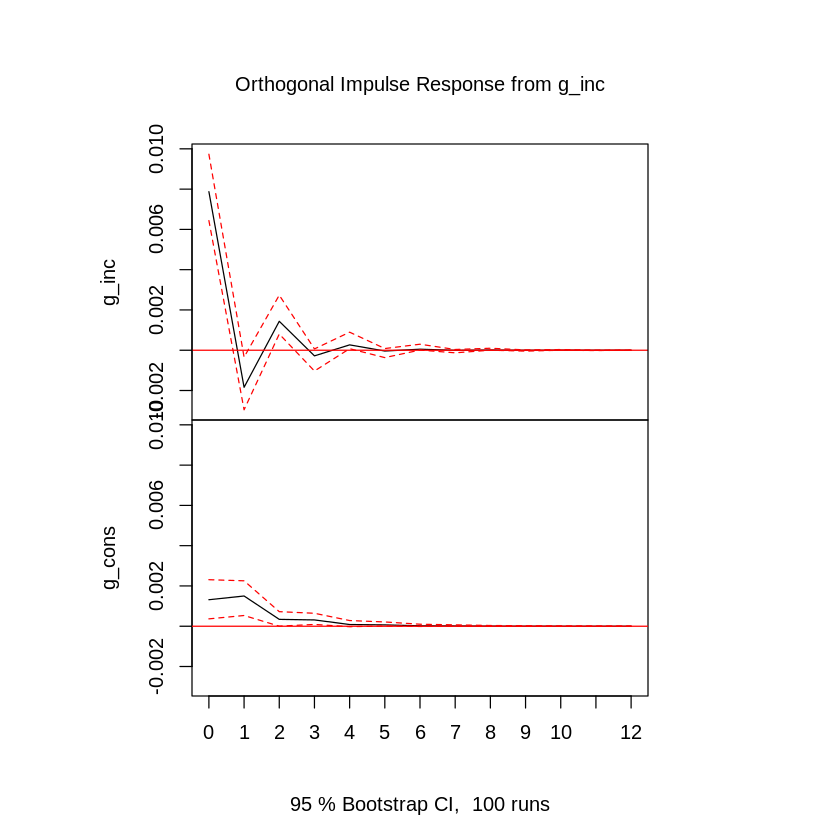

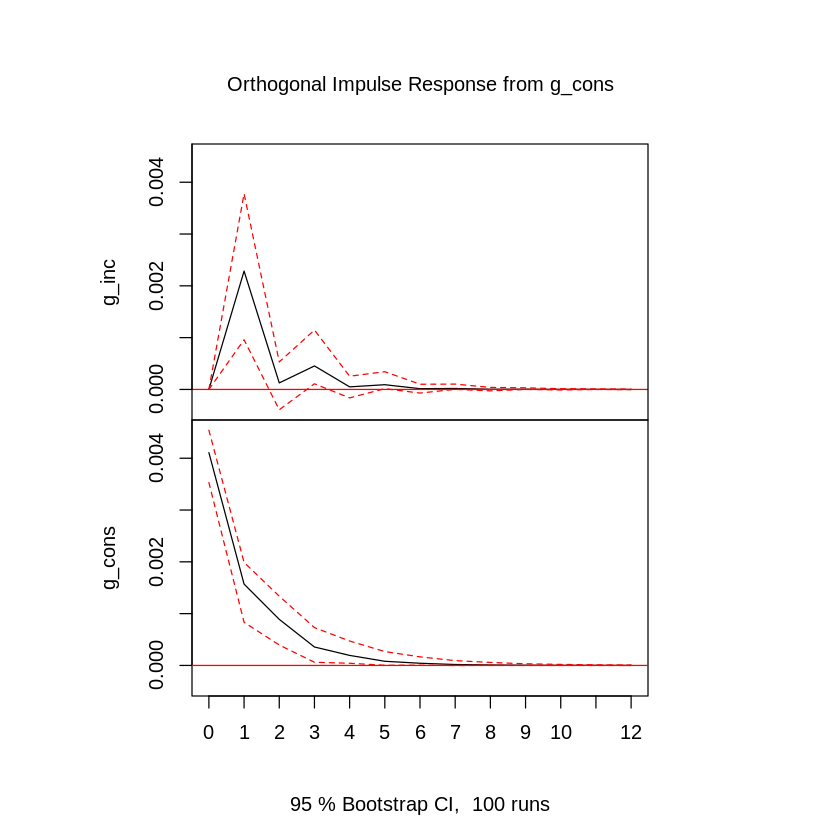

In [23]:
irf<-irf(var.1lag,n.ahead = 12,ortho = TRUE,ci=0.95)
plot(irf)

* Effet d'un choc sur g_inc :
**        un effet immédiat, positif et significatif sur le taux de croissance de la consommation jusqu'au second trimestre.

* Effet d'un choc sur g_cons :
**    pas d'impact immédiat sur le taux de croissance du revenu disponible,
**    un effet positif sur le revenu pour le trimestre suivant (à l'horizon h=1)

#### Estimation des IRF par les projections locales

On estime les IRF par la méthode des projections locales. On spécifie les paramètres suivants :

* le nombre d'horizon est égal à 12
* Pour chaque horizon $h=1,...,12$, le nombre de retards dans la régression de la projection locale sera au plus égal à 8 (max_lags = 8) et choisi par la minimisation du critère BIC
* on applique des chocs égaux à 1 écart type du choc structurel : shock_type = 0. (shock_type =1 pour des chocs )
* Intervalle de confiance à 95\% (confit=1.96) (confit = 1.65 pour un intervalle de confiance à 90% et confit=1 pour un intervalle de confiance à 68\%)

[[1]]
NULL


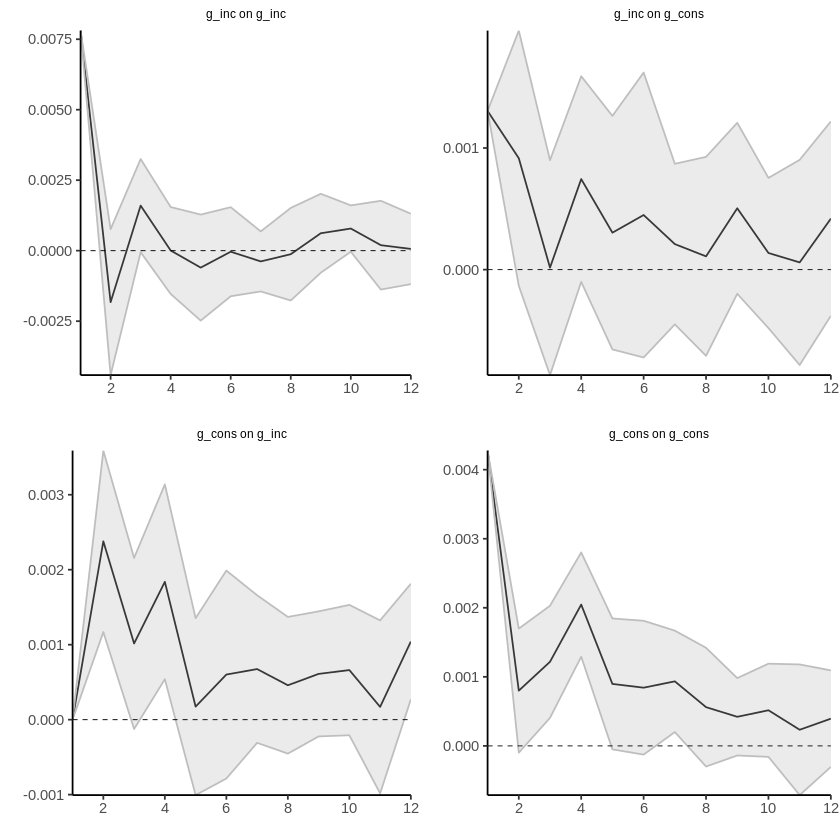

In [30]:
library(lpirfs)
irf_LP <-lp_lin(endog_data = df_g_short[, c(2, 3)],
                    lags_endog_lin = NaN,
                    lags_criterion = 'BIC',
                    max_lags = 8,
                    trend = 0,
                    shock_type = 0,
                    confint=1.96,
                    hor=12,
                    adjust_se=TRUE)

plot(irf_LP)

** Commentaires**

* impact d'un choc sur g_inc : peu de différence avec les fonctions obtenues à partir du VAR(1) (graphiques du haut)

* impact d'un choc sur g_cons :
    * l'impact du choc est plus durable sur g_inc
    * l'impact du choc est aussi plus durable sur g_cons
    * Explication possible : les fonctions impulsion réponse sont estimées en déterminant de façon endogène le nombre de retards pour chaque horizon.


On peut afficher les valeurs de fonctions impulsion-réponse pour les chocs sur g_inc (variable 1 du dataframe)

In [32]:
irf_LP$irf_lin_mean[,,1]

0.007805978,-0.0018259760,1.597588e-03,6.065962e-06,-0.0006009981,-3.764449e-05,-0.0003814607,-0.0001256139,0.0006180958,0.0007847352,1.946615e-04,0.0000613235,-0.0003254562
0.001304485,0.0009158394,1.655681e-05,7.445147e-04,0.0003039722,4.490305e-04,0.0002099041,0.0001092348,0.0005044560,0.0001368489,5.939004e-05,0.0004195909,-0.0002422048


On peut afficher les valeurs de fonctions impulsion-réponse pour les chocs sur g_cons (variable 2 du dataframe)

In [33]:
irf_LP$irf_lin_mean[,,2]

0.000000000,0.0023786263,0.001016169,0.001838470,0.0001739160,0.0006017788,0.0006749255,0.0004587258,0.0006105987,0.0006615307,0.0001703716,0.001042507,-0.0004170949
0.004276182,0.0008001524,0.001218040,0.002046363,0.0008972719,0.0008430222,0.0009345842,0.0005609018,0.0004214367,0.0005158122,0.0002336553,0.000394483,0.0004069005


L'affichage ci-dessous montre que le nombre de retards optimal inclus dans la projection locale varie selon la variable l'horizon, la variable qui subit un chocs et celle dont on étudie la dynamique.


In [34]:
irf_LP$specs$chosen_lags

1
3
1
2
1
1
1
1
1
1
1


#### Décomposition de la variance

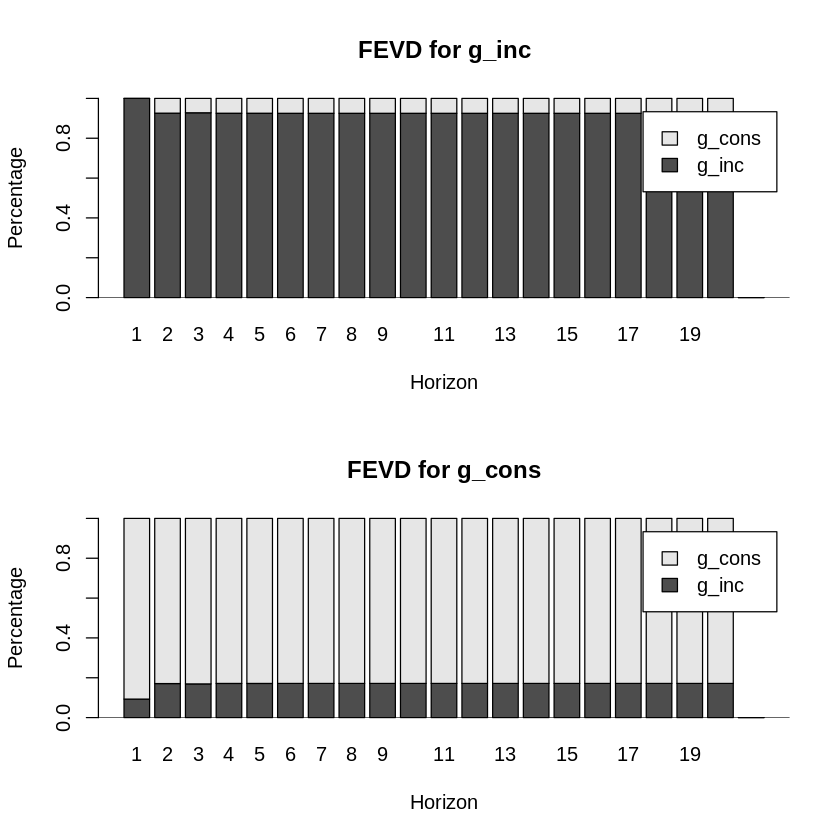

In [35]:
dec_var <-fevd(var.1lag,n.ahead=20)

plot(dec_var)


### Calcul des prévisions



On calcule les prévisions pour les 10 observations suivantes à partir du VAR(1)

         Length Class  Mode   
fcst       2    -none- list   
endog    238    -none- numeric
model     10    varest list   
exo.fcst   0    -none- NULL   

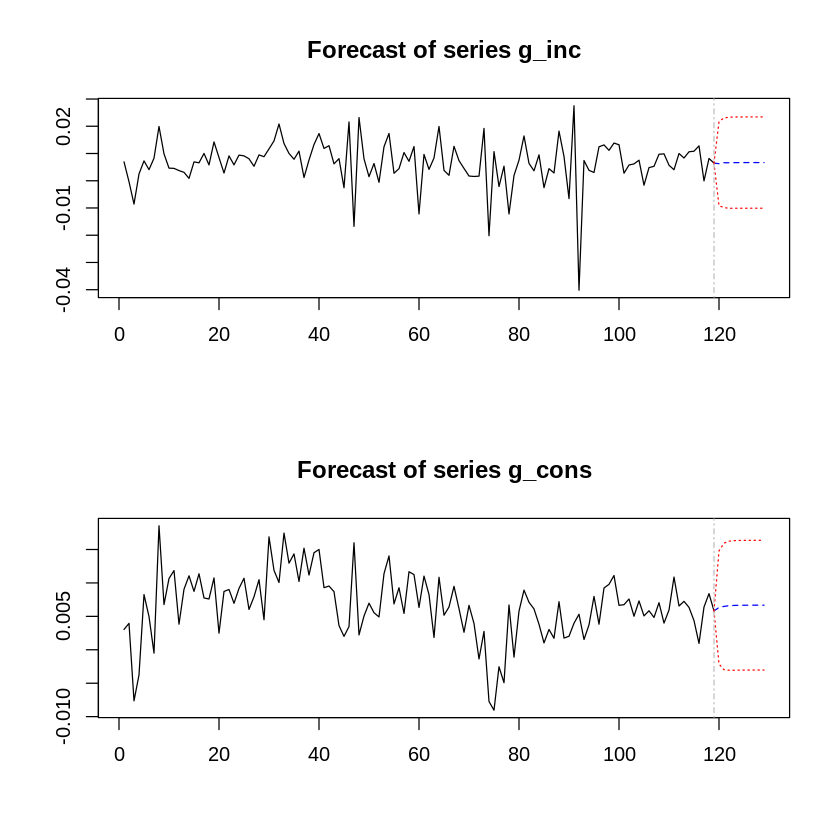

In [40]:
forecast<-predict(var.1lag,n.ahead = 10, ci=0.95)

summary(forecast)
plot(forecast)

### Ajout d'une variable indicatrice en 2013:T1

Sur le graphique des taux de croissance, on observe une valeur atypique pour le premier trimestre de 2013. CEtte baisse s'explique par des causes particulières liées à la distribution des salaires et des dividences en décembre 2012 et aux contributions des employés aux assurances sociales [cf BEA](https://www.bea.gov/news/2013/personal-income-and-outlays-january-2013). On introduit une variable indicatrice pour prendre en compte cette observation particulière.

In [37]:
library(vars)
df_g_short$dummy_2013T1<-as.numeric(df_g_short$date=="2013-01-01")
pselect<-VARselect(y=df_g_short[,c(2,3)],lag.max=8,type=c("const"),exogen = df_g_short$dummy_2013T1)
pselect$criteria # Affichage des valeurs des critère de sélection
pselect$selection # nombre de retards optimal selon les critères de sélection

Warning message in VARselect(y = df_g_short[, c(2, 3)], lag.max = 8, type = c("const"), :
“No column names supplied in exogen, using: exo1 , instead.
”


,1,2,3,4,5,6,7,8
AIC(n),-2.102441e+01,-2.107740e+01,-2.110390e+01,-2.110489e+01,-2.106510e+01,-2.101564e+01,-2.099071e+01,-2.094460e+01
HQ(n),-2.094519e+01,-2.095857e+01,-2.094547e+01,-2.090684e+01,-2.082744e+01,-2.073837e+01,-2.067383e+01,-2.058811e+01
SC(n),-2.082913e+01,-2.078447e+01,-2.071334e+01,-2.061668e+01,-2.047926e+01,-2.033215e+01,-2.020959e+01,-2.006583e+01
FPE(n),7.400186e-10,7.019311e-10,6.837668e-10,6.834238e-10,7.116719e-10,7.485083e-10,7.684329e-10,8.060949e-10


AIC(n)  HQ(n)  SC(n) FPE(n) 
     4      2      1      4

On obtient des résultats similaires à ceux du cas sans indicatrice.

#### Estimation du VAR(1) avec l'indicatrice pour 2013:T1

In [38]:
var.1lag_wd <-VAR(y = df_g_short[,c(2,3)],type="const",lag.max = 1,exogen = df_g_short$dummy_2013T1)
summary(var.1lag_wd) #Affichage des résultats avec summary

Warning message in VARselect(y, lag.max = lag.max, type = type, season = season, :
“No column names supplied in exogen, using: exo1 , instead.
”
Warning message in VAR(y = df_g_short[, c(2, 3)], type = "const", lag.max = 1, exogen = df_g_short$dummy_2013T1):
“No column names supplied in exogen, using: exo1 , instead.
”



VAR Estimation Results:
Endogenous variables: g_inc, g_cons 
Deterministic variables: const 
Sample size: 118 
Log Likelihood: 903.748 
Roots of the characteristic polynomial:
0.4672 0.3003
Call:
VAR(y = df_g_short[, c(2, 3)], type = "const", exogen = df_g_short$dummy_2013T1, 
    lag.max = 1)


Estimation results for equation g_inc: 
g_inc = g_inc.l1 + g_cons.l1 + const + exo1 

           Estimate Std. Error t value Pr(>|t|)    
g_inc.l1  -0.207802   0.081770  -2.541  0.01239 *  
g_cons.l1  0.459550   0.137298   3.347  0.00111 ** 
const      0.005343   0.001113   4.799 4.88e-06 ***
exo1      -0.041636   0.007235  -5.755 7.44e-08 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


Residual standard error: 0.006961 on 114 degrees of freedom
Multiple R-Squared: 0.3428,	Adjusted R-squared: 0.3255 
F-statistic: 19.82 on 3 and 114 DF,  p-value: 2.076e-10 


Estimation results for equation g_cons: 
g_cons = g_inc.l1 + g_cons.l1 + const + exo1 

            Estimate Std

* La variable indicatrice est négative et significative dans l'équation de g_inc. Elle n'est pas significative dans l'équation de g_conso, ce qui était attendu
* Les valeurs des coefficients de l'équation de g_inc sont un peu modifiés mais ne changent pas de signe
* le $R^{2}$ de l'équation de g_inc augmente et passe à 32\%

#### Tests de causalité et fonctions impulsion-réponse

Il n'y a pas de modification des résultats des tests de causalité ni des fonctions impulsion réponse

In [ ]:
causality(var.1lag_wd,cause=c('g_inc'))

In [ ]:
causality(var.1lag_wd,cause=c('g_cons'))

In [ ]:
irf2<-irf(var.1lag_wd,n.ahead = 12,ortho = TRUE,ci=0.95)
plot(irf2)

**Commentaires**

Peu de différences avec les impulsions-réponses précédentes sans la variable indicatrice.

## Etude sur la période 1990:T1 à 2023:T1



### Calcul et représentation des taux de croissance

In [39]:
df_g<-data.frame(df$date[-1],diff(log(df$income)),diff(log(df$consumption)))
colnames(df_g)<-c("date","g_inc","g_cons")

In [ ]:
library(ggplot2)
library(reshape)
data_melt=melt(as.data.frame(df_g[c(1,2,3)]),id.vars = 1)

p_g_us<-ggplot(data=data_melt,aes(x=date))+geom_line(aes(x=date,y=value,color= variable))
p_g_us+labs(y="taux",title = "Variation du revenu et de la consommation des ménages aux Etats-Unis",subtitle = "1990:T1 à 2023:T1")

Le graphique des taux de croissance montre que les observations allant du premier trimestre de 2020 au second semestre de 2021 sont atypiques par le niveau des taux de croissance à la hausse comme à la baisse. On décide d'introduire des variables indicatrices pour prendre en compte ces observations.

In [ ]:
tail(df_g,n=15)

### Estimation d'un modèle VAR

In [ ]:
df_g$dummy_2013T1<-as.numeric(df_g$date=="2013-01-01")
df_g$dummy_2020T1<-as.numeric(df_g$date=="2020-01-01")
df_g$dummy_2020T2<-as.numeric(df_g$date=="2020-04-01")
df_g$dummy_2020T3<-as.numeric(df_g$date=="2020-07-01")
df_g$dummy_2020T4<-as.numeric(df_g$date=="2020-10-01")
df_g$dummy_2021T1<-as.numeric(df_g$date=="2021-01-01")
df_g$dummy_2021T2<-as.numeric(df_g$date=="2021-04-01")

On cherche le nombre de retards optimal en ajoutant ces variables indicatrices en prenant 8 retards au maximum

In [ ]:
library(vars)
pselect<-VARselect(y=df_g[,c(2,3)],lag.max=8,type=c("const"),exogen = df_g[c(4,5,6,7,8,9,10)])
# Affichage des valeurs des critère de sélection
pselect$criteria
# nombre de retards optimal selon les critères de sélection
pselect$selection

On choisit d'estimer un modèle VAR(1).

In [ ]:
var.4lag_T_wd <-VAR(y = df_g[,c(2,3)],type="const",lag.max = 1,exogen = df_g[c(4,5,6,7,8,9,10)])
summary(var.4lag_T_wd) #Affichage des résultats avec summary

** Commentaires **

* équation de g_inc

    * les coefficients de g_inc.l1 et g_cons.l1 ne sont significatifs que pour un risque de première espèce de 10 \%. Les valeurs des coefficients sont très différentes de celles des estimations précédentes. L'inclusion de la période covid a un impact sur les estimations malgré l'inclusion des variables indicatrices.
    * toutes les indicatrices sauf dummy_2020T1 sont significatives pour un risque de première espèce de 1\%
    * le $R^{2}$ est égal à 74,4%
    
* équation de g_cons
    * les coefficients de g_inc.l1 et g_cons.l1 ne sont significatifs que pour un risque de première espèce de 1 \%. Les valeurs des coefficients sont assez proches de celles des estimations précédente
    * dummy_2020T4 est significative pour  un risque de première espèce de 10 %. Toutes les autres indicatrices sauf dummy_2013T1 et dummy_2021T2 sont significatives pour un risque de première espèce de 1\%.
    * le $R^{2}$ est égal à 83,4%

Nous observons que les indicatrices sont significatives pour au moins une équation, voire les deux.



### Tests de causalité au sens de Granger

In [ ]:
causality(var.4lag_T_wd,cause=c('g_inc'))

On rejette l'hypothèse nulle d'absence de causalité de g_inc sur g_cons pour un risque de première espèce de 1\%.


In [ ]:
causality(var.4lag_T_wd,cause=c('g_cons'))

On rejette l'hypothèse nulle d'absence de causalité de g_cons sur g_inc pour un risque de première espèce de 10\% seulement.


### Estimation des fonctions impulsion réponse

On garde le même ordre des variables pour le calcul des chocs structurels par la méthode de Cholesky.

In [ ]:
irf3<-irf(var.4lag_T_wd,n.ahead = 12,ortho = TRUE,ci=0.95)
plot(irf3)


Un choc sur g_cons n'a plus d'effet significatif sur g_inc.